In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
from PIL import Image
import numpy as np
import utils
import matplotlib.pyplot as plt

In [2]:
import simm

In [3]:
args = {}
args["data_dir"] = "data/autoencoder_img"
args["data"] = "anamoly"
args["lr"] = 0.001

In [4]:
dataloaders, dataset_sizes = utils.get_dataloaders(
            args["data"], args["data_dir"], ["train", "val"]
        )

In [5]:
import timm
import torch.nn.functional as F
class UNet(nn.Module):
    def __init__(self, op_channels=4, encoder_name='resnet18.a1_in1k'):
        super(UNet, self).__init__()
        self.encoder = timm.create_model(encoder_name, pretrained=True, features_only=True, out_indices=[4])

        if encoder_name.split(".")[0] == "resnet50":
            self.decoder = nn.Sequential(
                nn.ConvTranspose2d(2048, 512, kernel_size=4, stride=2, padding=1),
                nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
                nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
                nn.ReLU(inplace=True),
                nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
                nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(32, op_channels, kernel_size=3, padding=1),
                nn.Sigmoid()
            )
        if encoder_name.split(".")[0] == "resnet18":
            self.decoder = nn.Sequential(
                nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
                nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
                nn.ReLU(inplace=True),
                nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
                nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
                nn.ReLU(inplace=True),
                nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True),
                nn.Conv2d(32, op_channels, kernel_size=3, padding=1),
                nn.Sigmoid()
            )
        # self.upsample = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)

    def forward(self, x):
        encoder_features = []
        encoder_features = self.encoder(x)
        x = encoder_features[-1].clone()
        x = F.interpolate(x, size=(8, 8), mode='nearest')
        x = self.decoder(x)
        return x, encoder_features[-1]

/Users/rishitoshsingh/miniconda3/envs/dl-asign/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
def get_device(device_str):
    if device_str == "gpu" and torch.cuda.is_available():
        return torch.device("cuda")
    elif device_str == "cpu":
        return torch.device("cpu")
    elif device_str == "mps" and torch.backends.mps.is_available():
        return torch.device("mps")  # You can modify the GPU index if needed
    else:
        print("Warning: Invalid device option. Using CPU.")
        return torch.device("cpu")
device = get_device("mps")

In [7]:
model = UNet(op_channels=1, encoder_name="resnet50.a1_in1k")
# loss_fn = nn.MSELoss()
loss_fn = simm.SSIMLoss()
optimizer = optim.Adam(model.parameters(), lr=args["lr"])
model = model.to(device)

In [8]:
def image_to_arrag(image):
    return image.permute(1, 2, 0).cpu().detach().numpy().astype("float")

In [66]:
images, masks = next(iter(dataloaders["train"]))
print(images.shape, masks.shape)

torch.Size([4, 1, 256, 256]) torch.Size([4, 1, 256, 256])


In [9]:
from tqdm import tqdm

In [11]:
from torchsummary import summary
summary(model, (3, 256, 256))

AttributeError: 'tuple' object has no attribute 'to'

In [12]:
def train_model(model, loss_fn, optimizer, dataloaders, dataset_sizes, num_epochs):
    model.train()
    train_losses, val_losses = [], []
    for epoch in range(num_epochs):
        for phase in ["train", "val"]:
            if phase=="train":
                model.train()
            else:
                model.eval()
            running_loss=0.0
            with tqdm(total=len(dataloaders[phase]), desc=f'{phase.capitalize()} Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
                for inputs, labels in dataloaders[phase]:
                    inputs, labels = inputs.to(device), labels.to(device)
                    optimizer.zero_grad()
                    with torch.set_grad_enabled(phase=="train"):
                        outputs, _ = model(inputs.repeat(1, 3, 1, 1))
                        loss = loss_fn(outputs, labels)
                        if phase=="train":
                            loss.backward()
                            optimizer.step()
                        running_loss += loss.item()
                    pbar.update(1)
            epoch_loss = running_loss / dataset_sizes[phase]
            if phase=="train":
                train_losses.append(epoch_loss)
            else:
                val_losses.append(epoch_loss)
        print(f"Epoch {epoch+1}/{num_epochs} -> Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

    return model, train_losses, val_losses

model, train_losses, val_losses = train_model(model, loss_fn, optimizer, dataloaders, dataset_sizes, 10)

Train Epoch 1/10:   0%|          | 0/50 [00:00<?, ?batch/s]

Val Epoch 1/10: 100%|██████████| 8/8 [00:24<00:00,  3.01s/batch]


Epoch 1/10 -> Train Loss: 0.0844, Val Loss: 0.0919


Val Epoch 2/10: 100%|██████████| 8/8 [00:23<00:00,  2.96s/batch]


Epoch 2/10 -> Train Loss: 0.0547, Val Loss: 0.0538


Train Epoch 3/10:   0%|          | 0/50 [00:01<?, ?batch/s]


KeyboardInterrupt: 

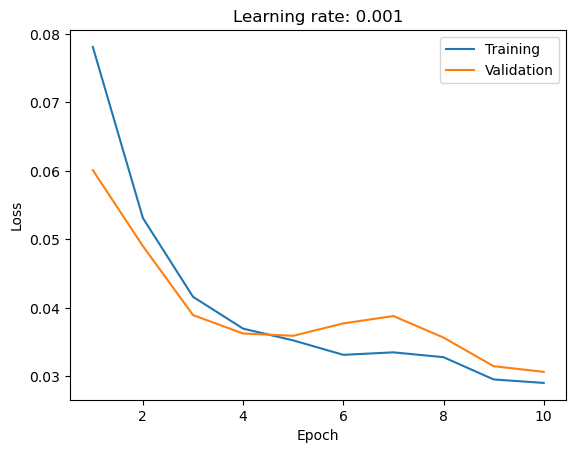

In [16]:
def plot_loss(train_losses, val_losses, learning_rate):
    plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training")
    plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Learning rate: {learning_rate}")
    plt.legend()
    plt.show()
plot_loss(train_losses, val_losses, args["lr"])

In [23]:
dataloaders, dataset_sizes = utils.get_dataloaders(
            args["data"], args["data_dir"], ["test"]
        )

In [17]:
def test_model(model, loss_fn, dataloader, dataset_size):
    model.eval()
    test_loss = 0.0
    all_outputs = []
    all_targets = []
    all_inputs = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs, _ = model(inputs.repeat(1,3,1,1))
            loss = loss_fn(outputs, labels)
            test_loss += loss.item()
            all_outputs.append(outputs.cpu())
            all_targets.append(labels.cpu())
            all_inputs.append(inputs.cpu())
    test_loss = test_loss / dataset_size
    all_inputs, all_outputs, all_targets = torch.cat(all_inputs), torch.cat(all_outputs), torch.cat(all_targets)
    print(f"Test Loss: {test_loss:.4f}")
    return all_inputs, all_outputs, all_targets
inputs, outputs, targets = test_model(model, loss_fn, dataloaders["val"], dataset_sizes["val"])

Test Loss: 0.0306


In [18]:
def image_to_arrag(image):
    return image.permute(1, 2, 0).cpu().detach().numpy().astype("float")

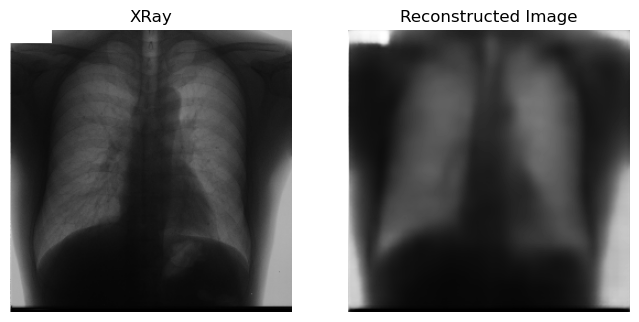

In [19]:
def plot_result(ip, output):
    fig = plt.figure(figsize=(8,4))
    fig.add_subplot(121)
    plt.imshow(image_to_arrag(ip), cmap="gray")
    plt.title("XRay")
    plt.axis('off')
    fig.add_subplot(122)
    plt.imshow(image_to_arrag(output), cmap="gray")
    plt.title("Reconstructed Image")
    plt.axis('off')
    plt.show()
idx=2
plot_result(inputs[idx], outputs[idx])

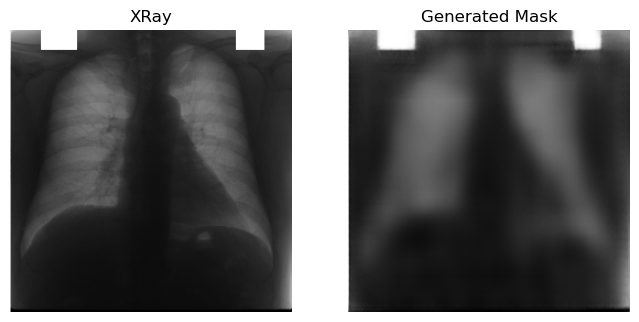

In [27]:
def plot_result(ip, output):
    fig = plt.figure(figsize=(8,4))
    fig.add_subplot(121)
    plt.imshow(image_to_arrag(ip), cmap="gray")
    plt.title("XRay")
    plt.axis('off')
    fig.add_subplot(122)
    plt.imshow(image_to_arrag(output), cmap="gray")
    plt.title("Reconstructed Image")
    plt.axis('off')
    plt.show()
idx=2
plot_result(inputs[idx], outputs[idx])